In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from source.beziercurve import BezierCurve
from source.diffrasterizer import rasterize_spheres
from source.utils import load_scene
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import plotly 
import plotly.graph_objects as go
from PIL import Image

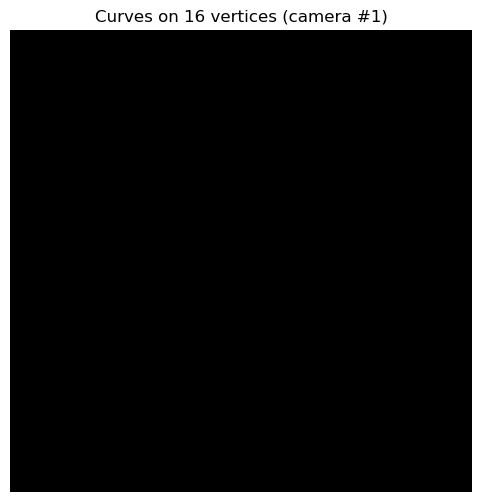

In [20]:
import torch
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from PIL import Image


def visualize_model_beziers(
    obj_path: str,
    transforms_json: str,
    camera_idx: int = 0,
    eps: float = 1e-2,
    curve_thickness: float = 1,
    arc_samples: int = 200,
    width: int = 800,
    height: int = 800,
    device: str = "cuda"
):
    # 1) Load cameras
    _, c2w_all, K = load_scene(transforms_json, width, height, device=device)
    c2w = c2w_all[camera_idx]
    w2c = torch.linalg.inv(c2w).to(device)
    K   = K.to(device)

    # 2) Load your mesh vertices
    mesh = trimesh.load(obj_path, process=False)
    verts = np.array(mesh.vertices, dtype=np.float32)
    # OPTIONAL: subsample if too many
    # verts = verts[::10]

    # 3) Build tiny Bézier per vertex
    init_pts_list = []
    for v in verts:
        base = torch.tensor(v, dtype=torch.float32, device=device)
        # 4 random control points around v
        offs = torch.randn(4, 3, device=device) * eps
        init_pts_list.append(base.unsqueeze(0) + offs)  # (4,3)

    # 4) Instantiate curves and sample them
    all_means = []
    all_radii = []
    for pts in init_pts_list:
        curve = BezierCurve(
            pts,
            thickness=curve_thickness,
            overlap=0.8,
            arc_samples=arc_samples,
            device=device
        )
        m, r = curve()             # m: (M,3), r: (M,)
        all_means.append(m)
        all_radii.append(r)

    means   = torch.cat(all_means, dim=0)
    radii   = torch.cat(all_radii, dim=0)
    viewmat = w2c.to(dtype=means.dtype)

    # 5) Rasterize all the little spheres in one go
    img_t = rasterize_spheres(
        means=means,
        radii_world=radii,
        viewmat=viewmat,
        K=K,
        width=width,
        height=height
    )  # (H,W,1)

    # 6) Convert to PIL and show
    img_np = (img_t[...,0].cpu().detach().numpy() * 255.0).clip(0,255).astype("uint8")
    img_pil = Image.fromarray(img_np, mode="L")
    plt.figure(figsize=(6,6))
    plt.imshow(img_pil, cmap="gray")
    plt.axis("off")
    plt.title(f"Curves on {len(verts)} vertices (camera #{camera_idx})")
    plt.show()


visualize_model_beziers(
    obj_path   = "../data/elko_debug.obj",
    transforms_json = "../data/Elko/transforms_train.json",
    camera_idx = 1,
    eps        = 1e-2,
    curve_thickness = 0.02,
    arc_samples=300,
    width      = 800,
    height     = 800,
    device     = "cuda"
)

In [4]:
# 1) load scene
image = 9
device = 'cuda'
W, H = 800, 800
file_paths, c2w_mats, K = load_scene("../data/transforms_train.json", W, H, device=device)

# 2) pick center-of-scene camera (index 0 or whichever frames around center)
c2w = c2w_mats[image]                # camera-to-world
w2c = torch.linalg.inv(c2w)      # world-to-camera

# 3) instantiate Bezier curve around scene center
#    here control points in [-1,1]^3 space around the origin
init_pts1 = torch.tensor([
    [-1.0, 0.0, 0.0],
    [-0.5, 0.5, 0.2],
    [ 0.5,-0.5, 0.3],
    [ 1.0, 0.0, 0.0]
], dtype=torch.float16, device='cuda')

init_pts2 = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.5, 0.5, 0.2],
    [ 0.5,-0.5, 0.3],
    [ 1.0, 0.0, 0.0]
], dtype=torch.float16, device='cuda')

bez1 = BezierCurve(init_pts1, thickness=0.05, overlap=0.9, arc_samples=300, device=device)
bez2 = BezierCurve(init_pts2, thickness=0.05, overlap=0.9, arc_samples=300, device=device)

# 4) sample curve
means1, thicknesses1 = bez1()
means2, thicknesses2 = bez2()
viewmat = w2c.to(dtype=means1.dtype)
K = K.to(dtype=means1.dtype)
# 5) render all spheres along the curve
means = torch.cat([means1, means2], dim=0)  # (N,3)
thicknesses = torch.cat([thicknesses1, thicknesses2], dim=0)  # (N,1)
means = means.to(device)
thicknesses = thicknesses.to(device)
img_t = rasterize_spheres(
    means=means,
    radii_world=thicknesses,
    viewmat=viewmat,
    K=K,
    width=W,
    height=H
)  # (H,W,1)

# 6) convert & show
img_np = (img_t[...,0].cpu().detach().numpy()*255).astype("uint8")
img_pil = Image.fromarray(img_np, mode="L")


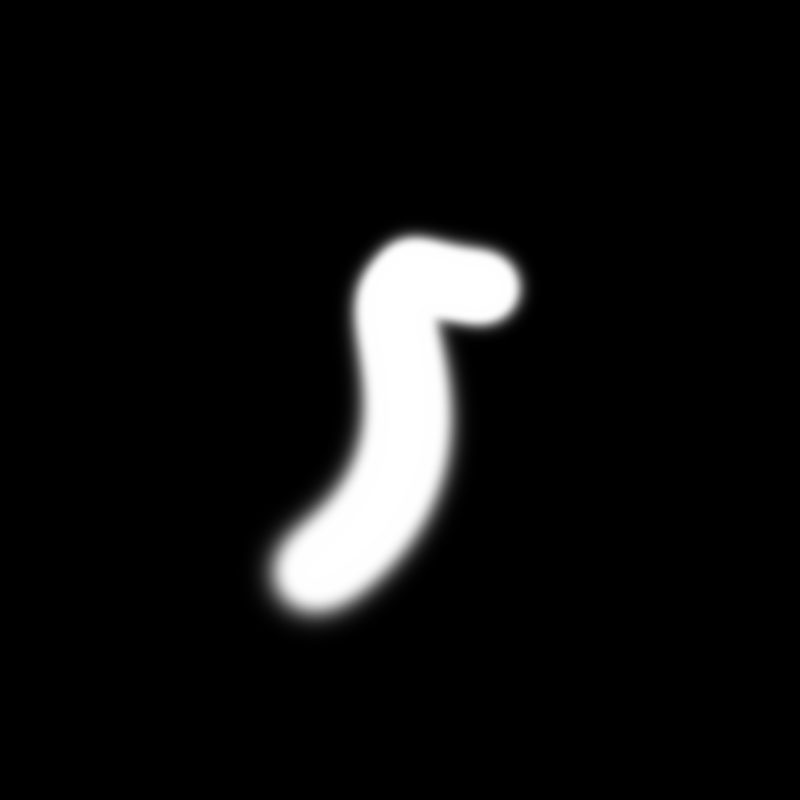

In [5]:
img_pil

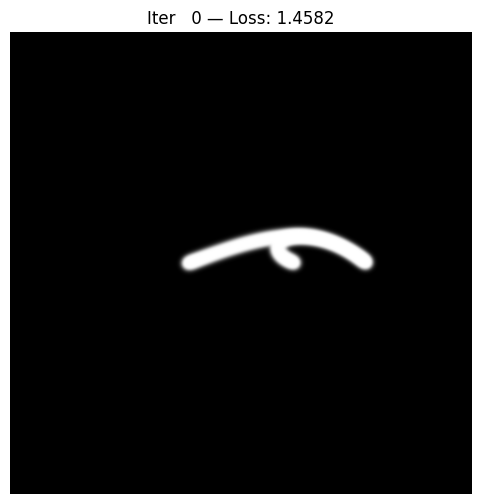

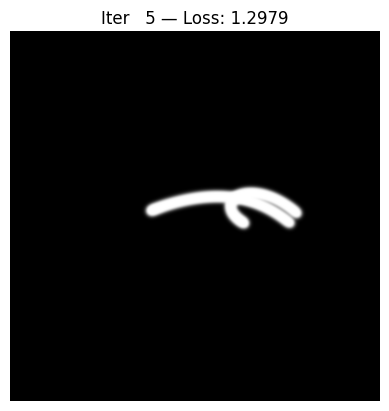

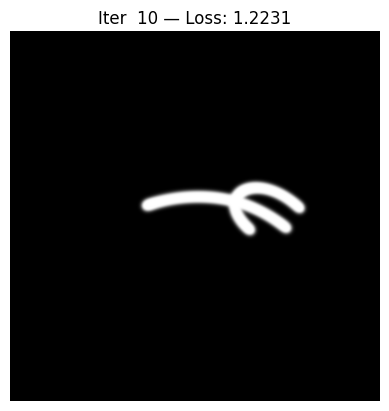

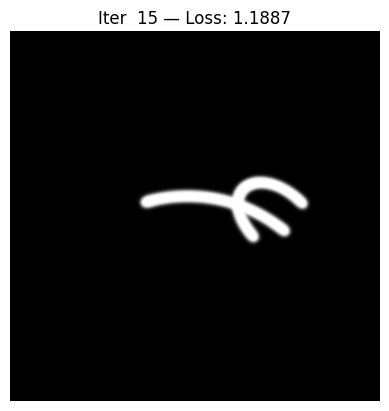

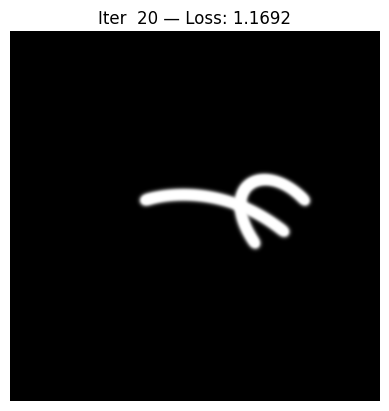

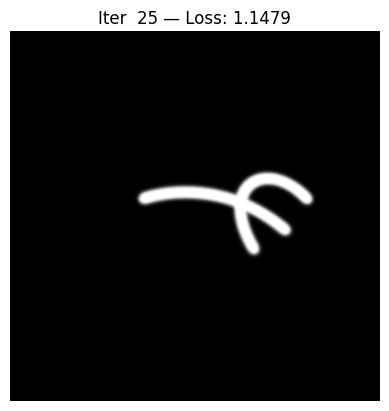

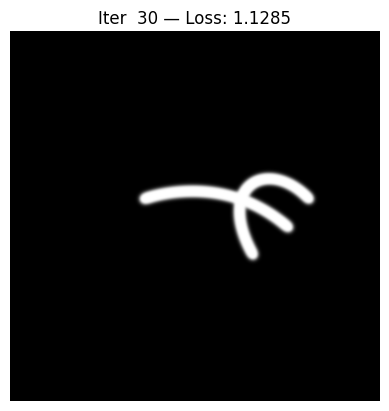

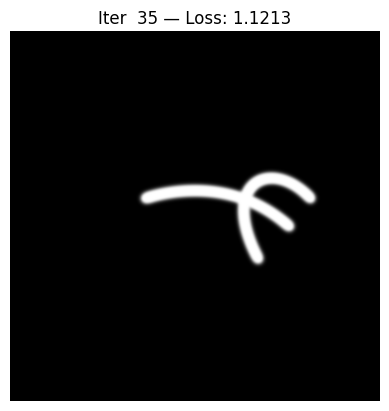

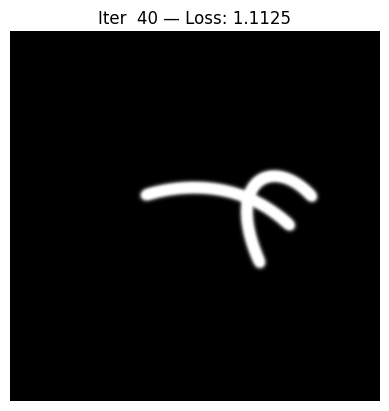

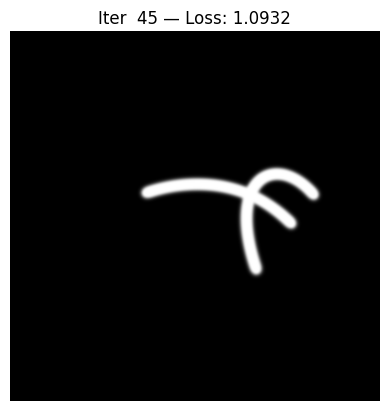

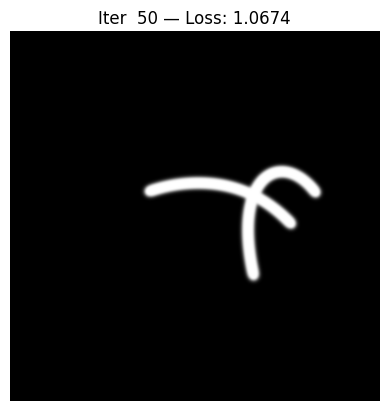

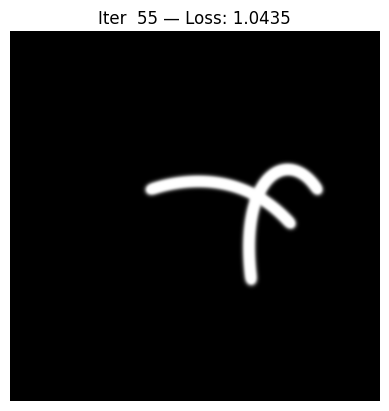

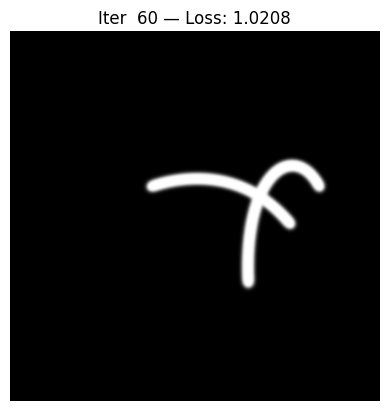

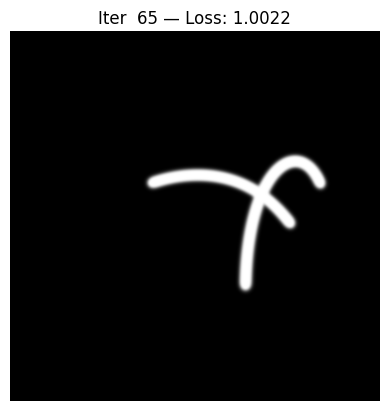

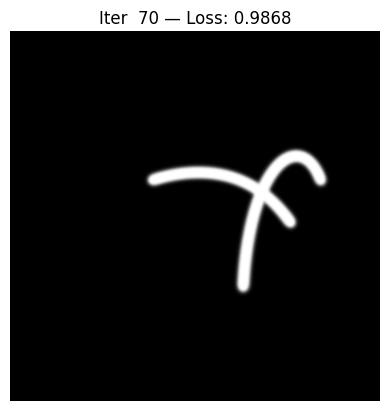

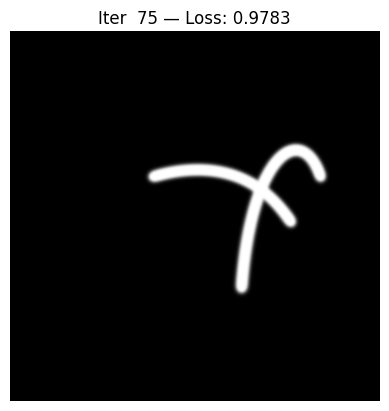

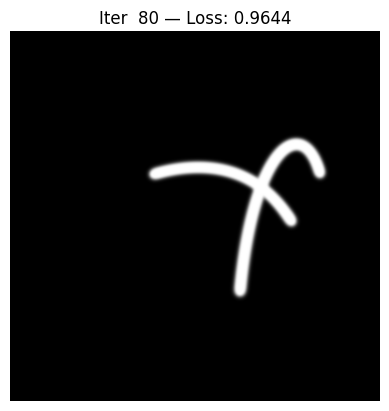

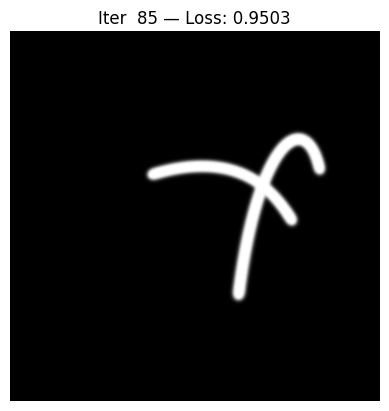

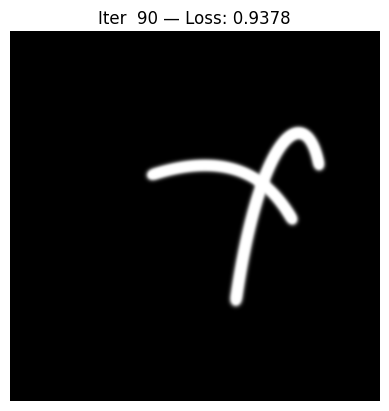

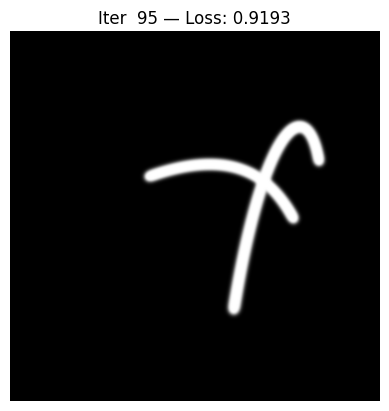

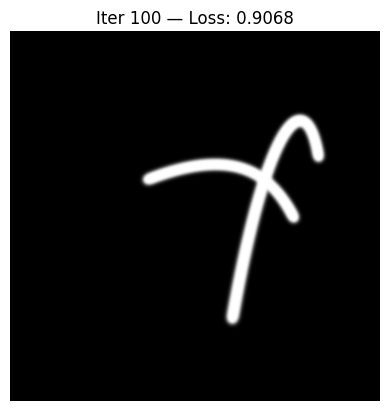

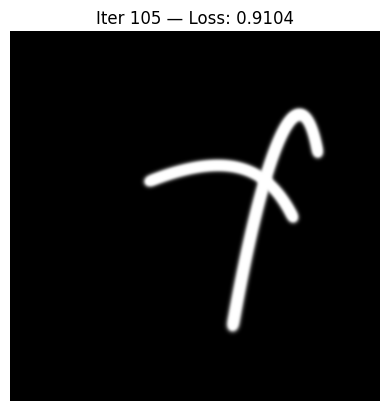

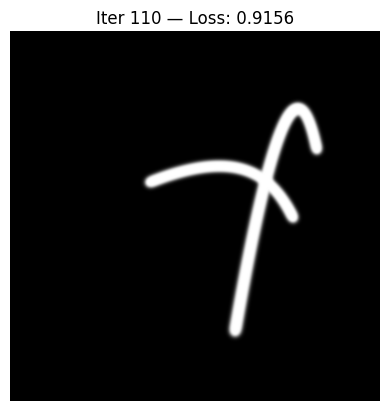

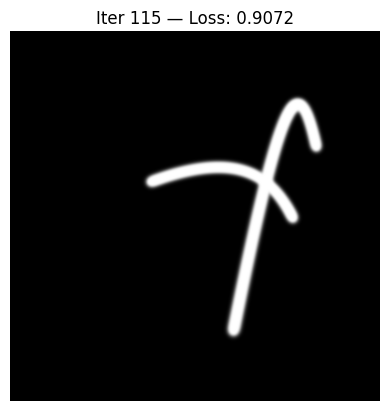

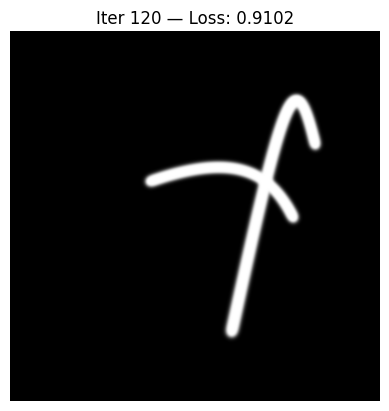

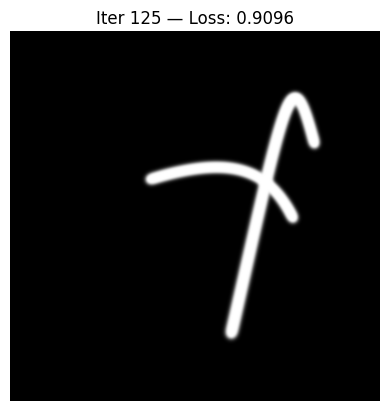

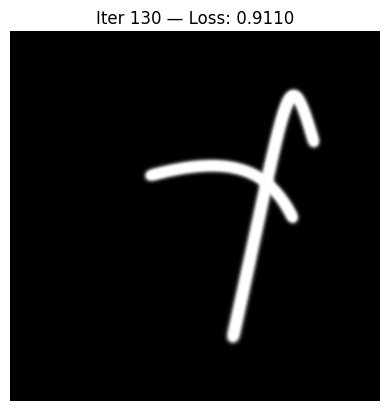

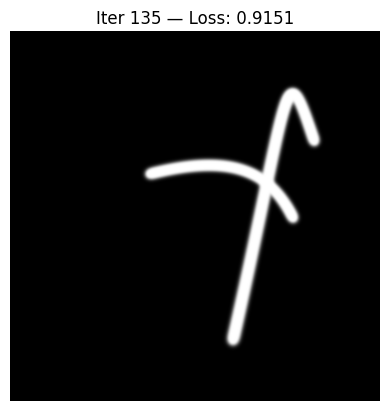

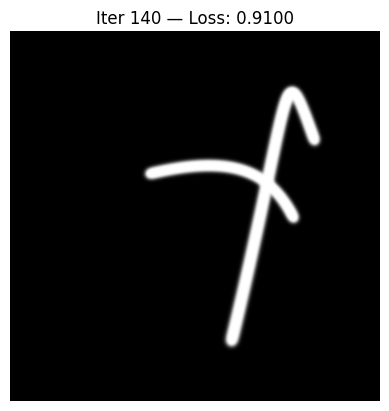

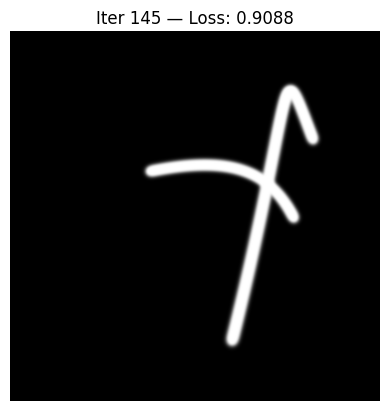

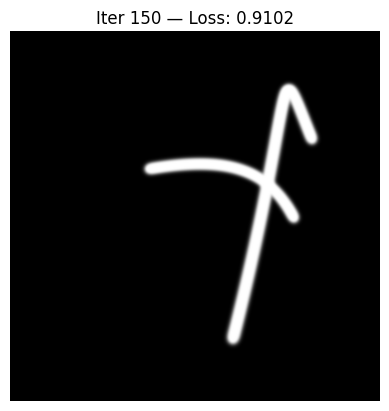

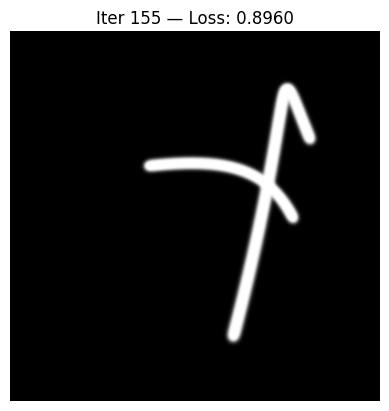

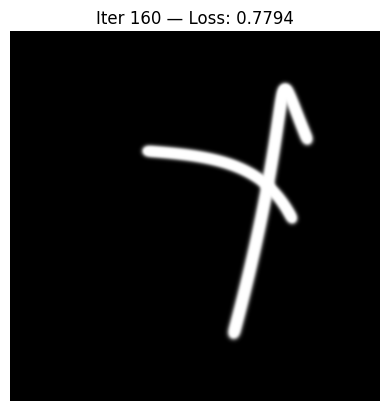

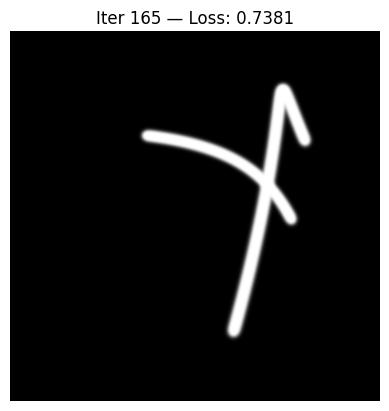

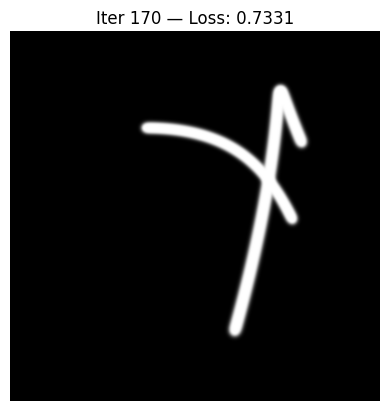

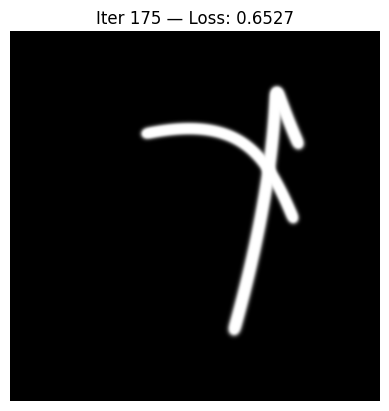

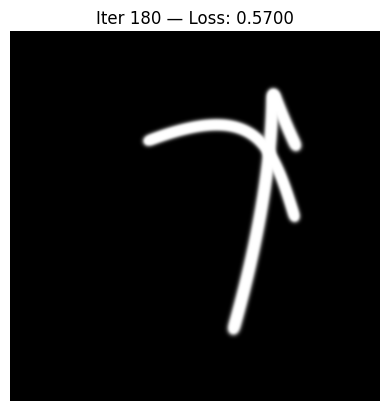

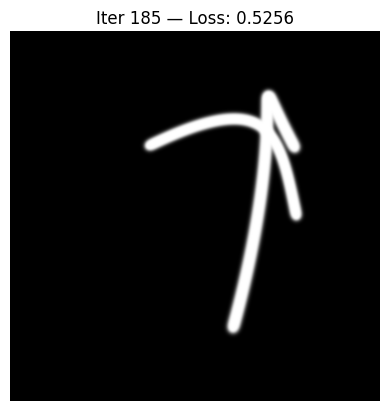

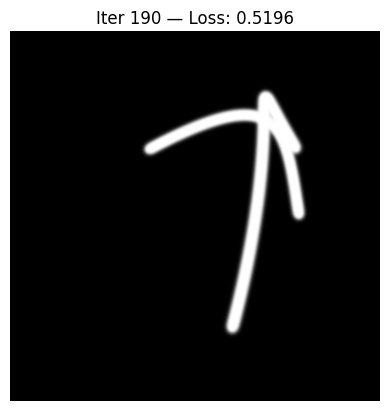

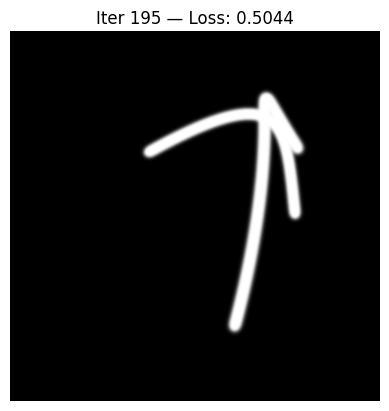

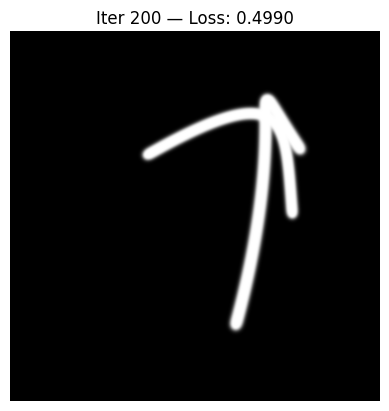

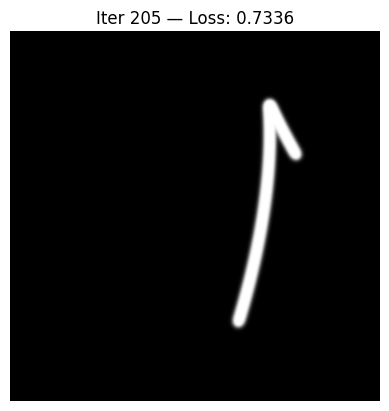

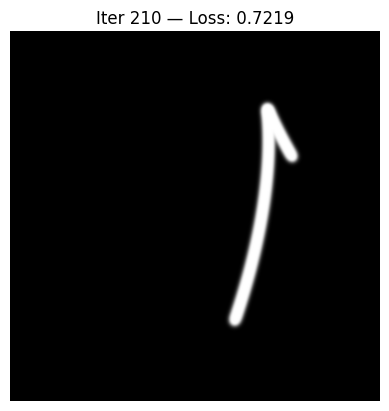

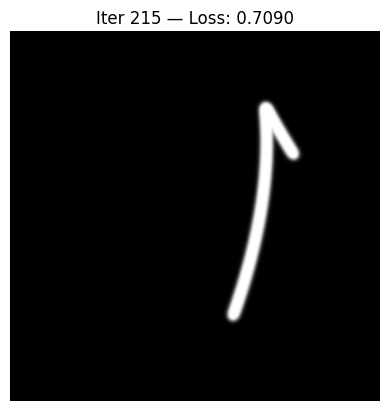

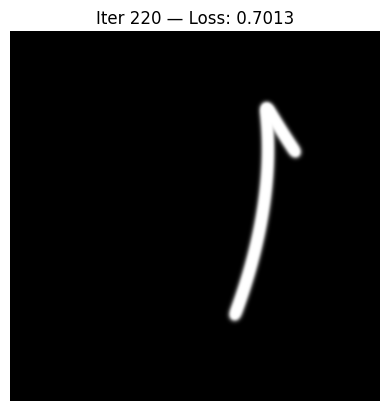

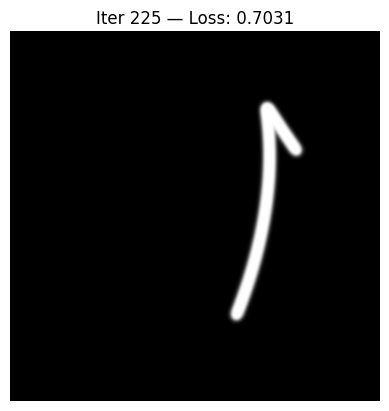

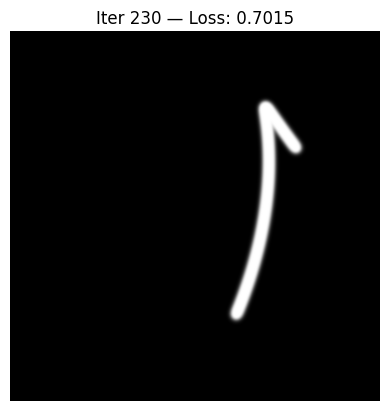

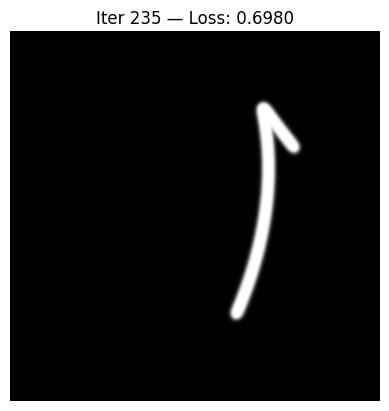

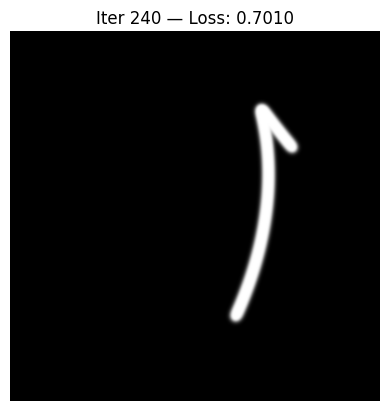

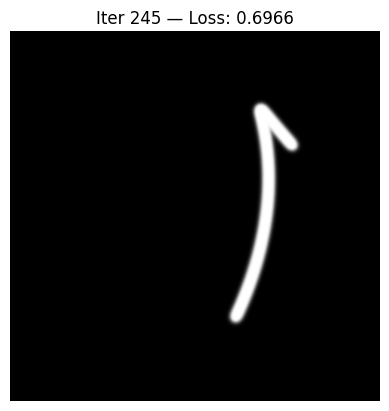

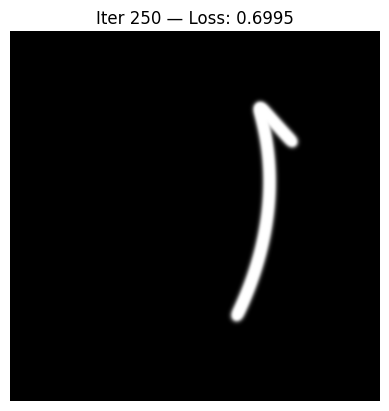

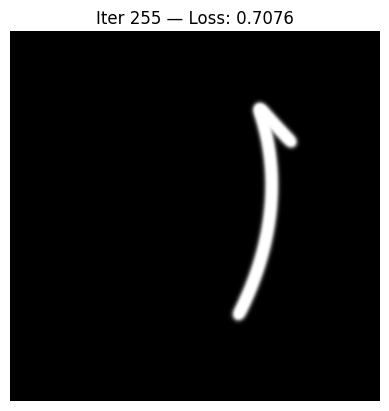

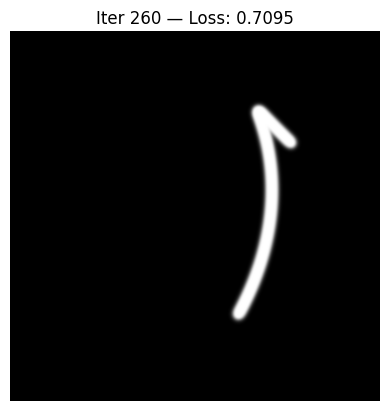

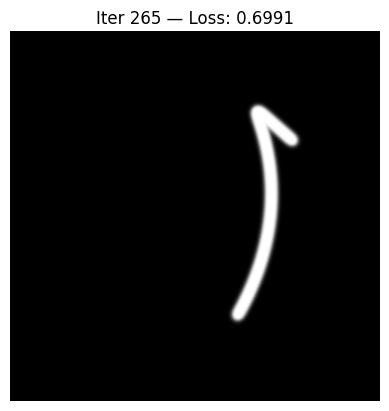

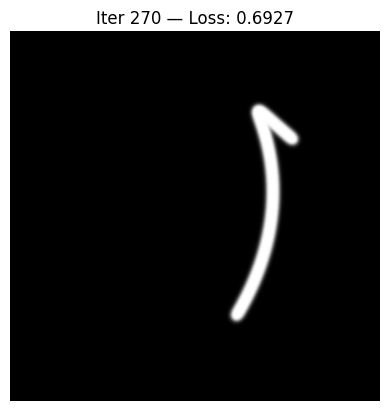

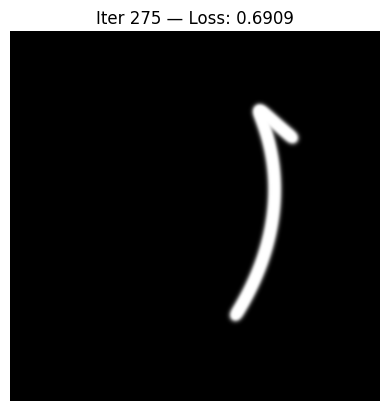

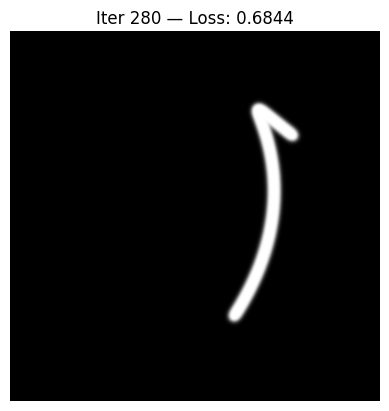

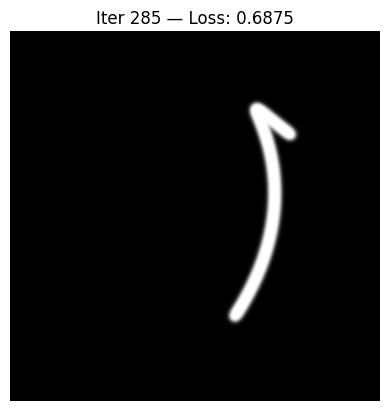

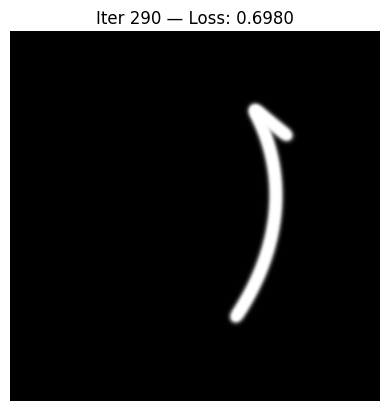

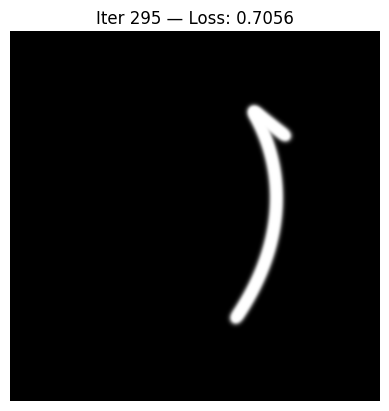

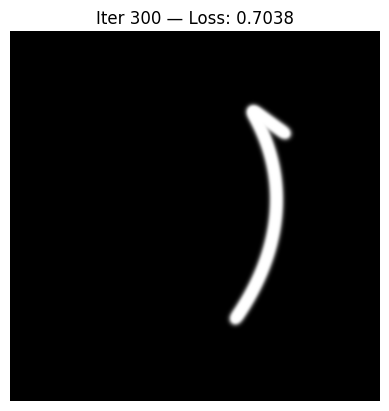

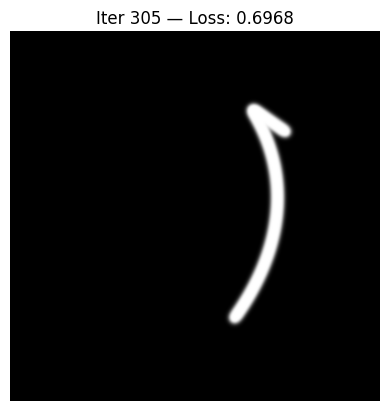

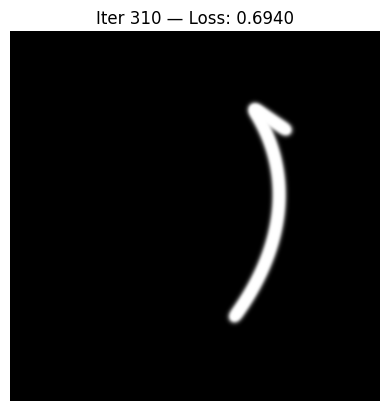

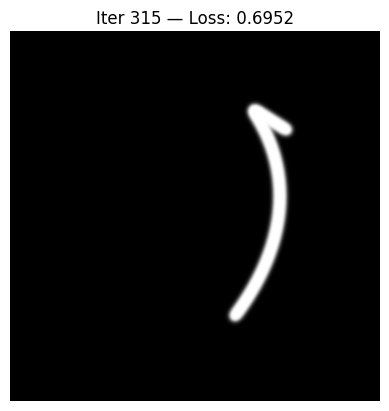

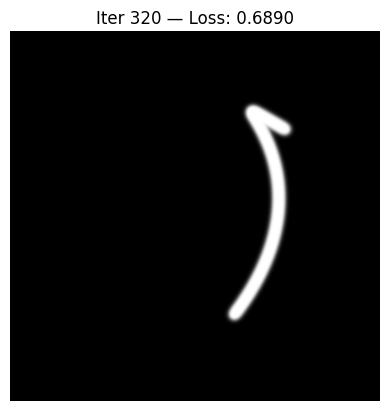

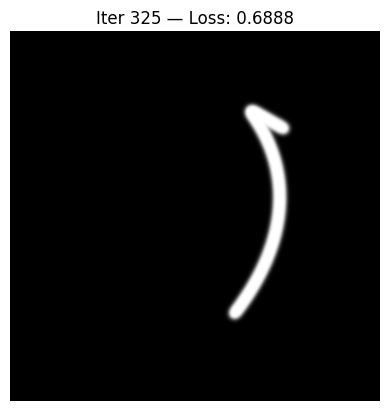

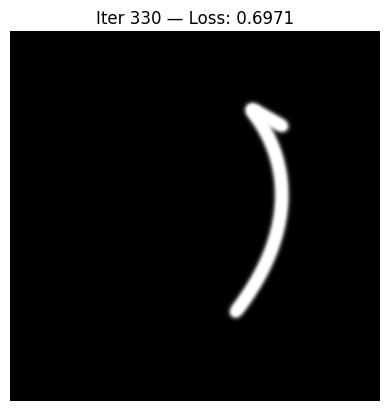

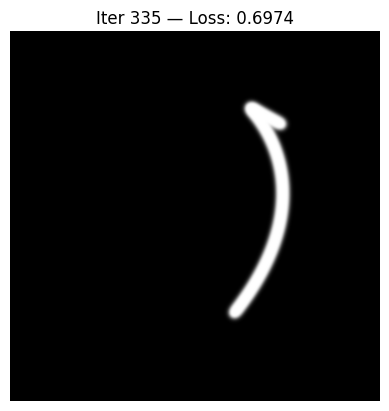

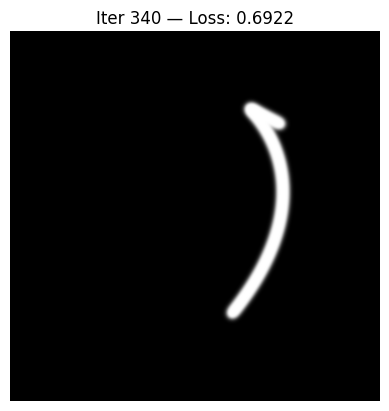

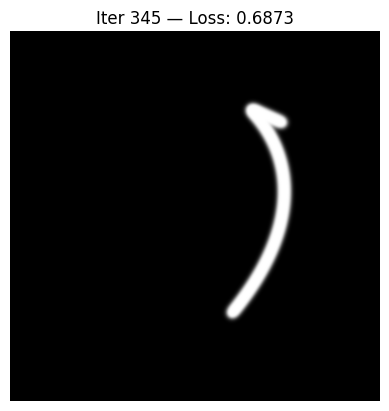

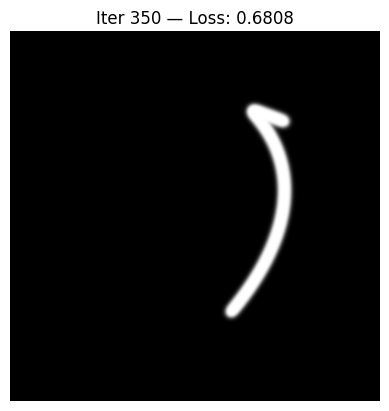

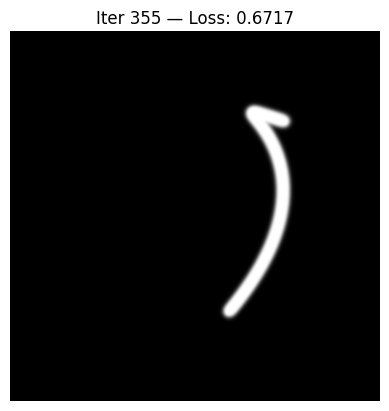

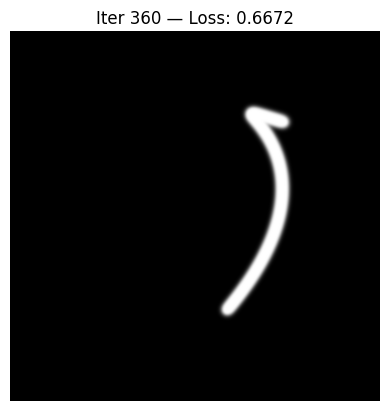

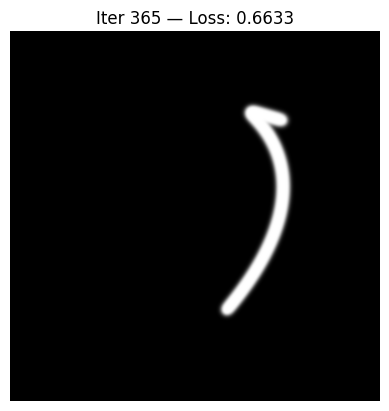

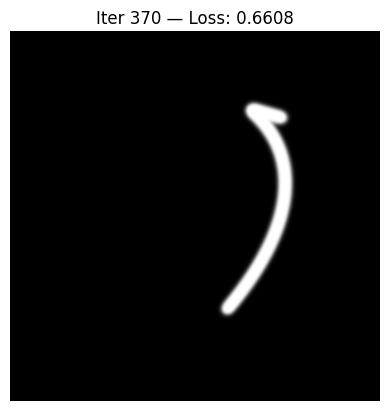

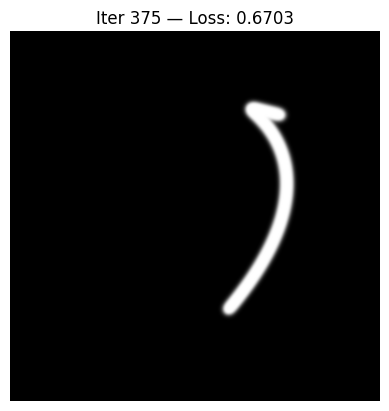

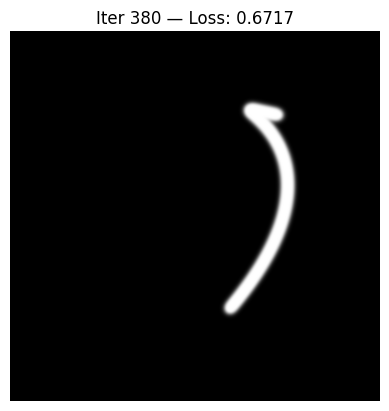

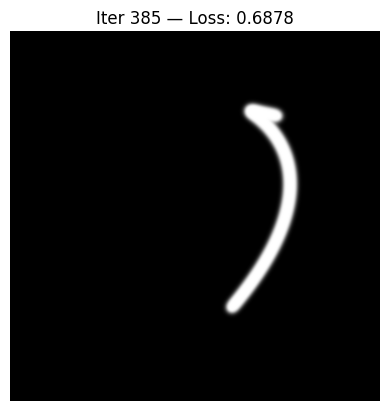

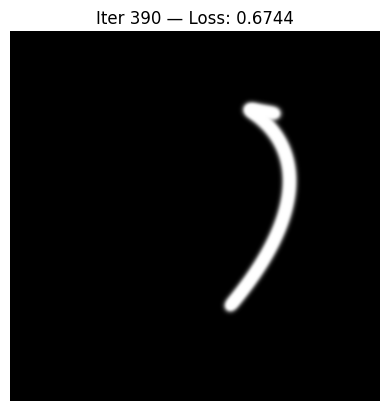

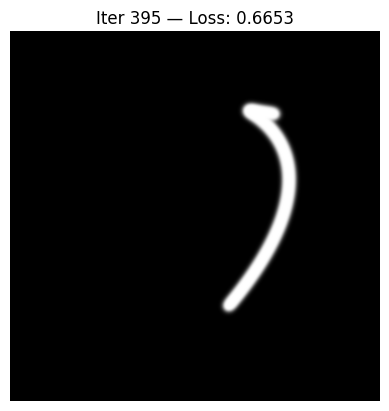

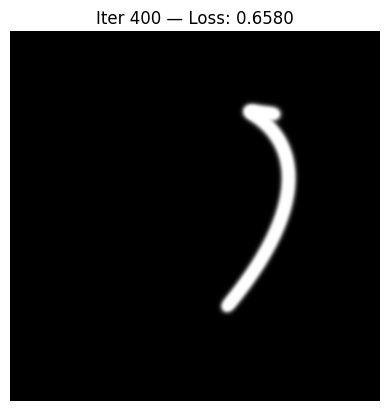

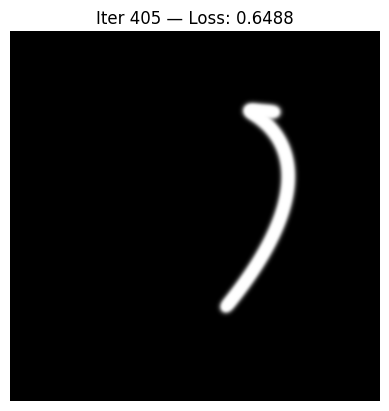

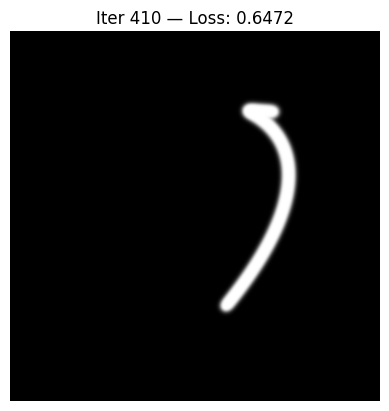

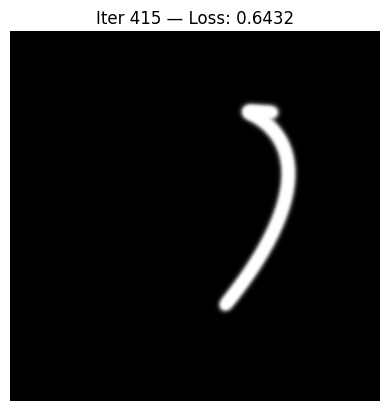

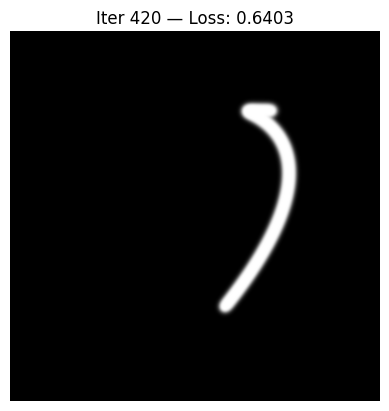

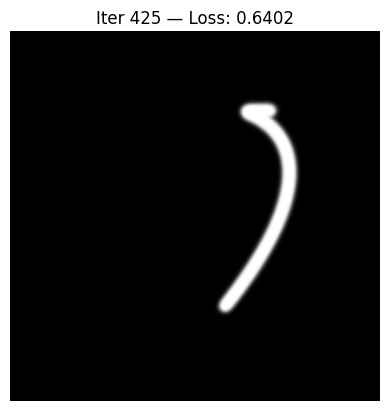

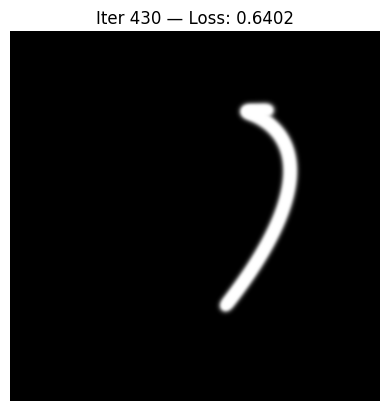

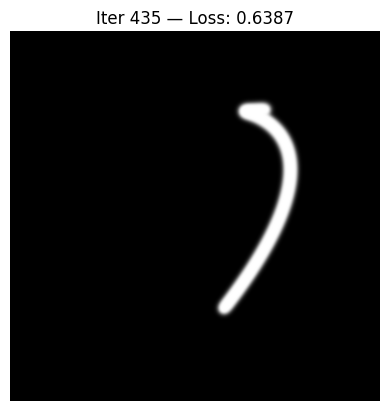

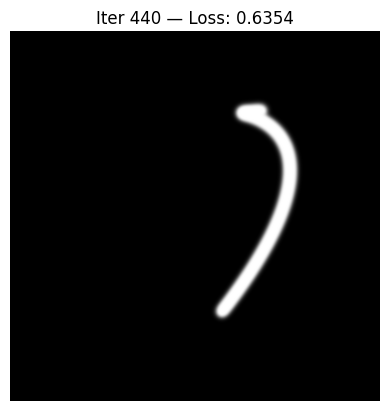

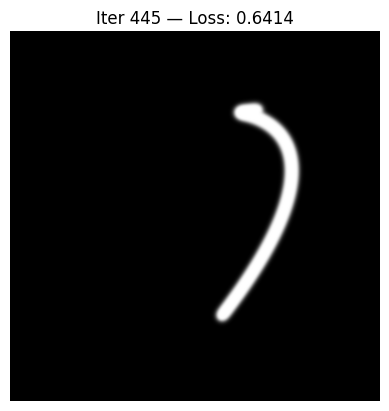

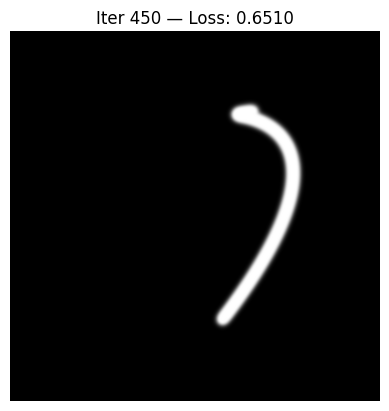

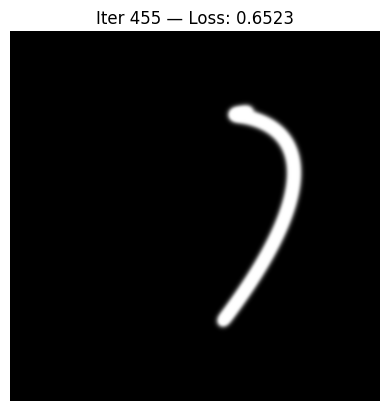

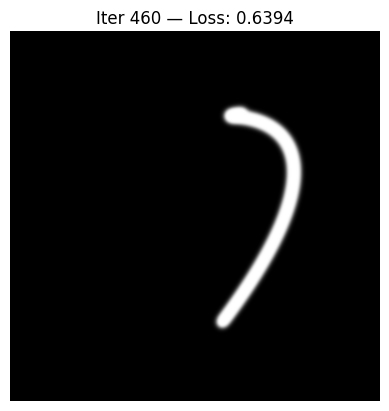

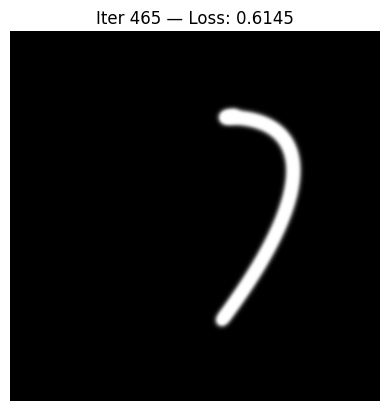

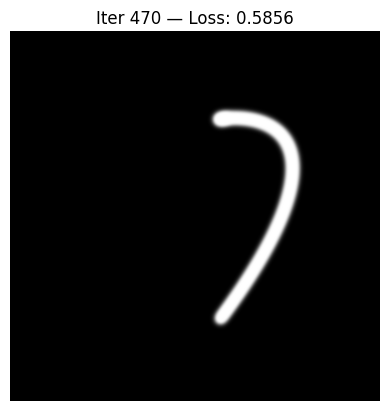

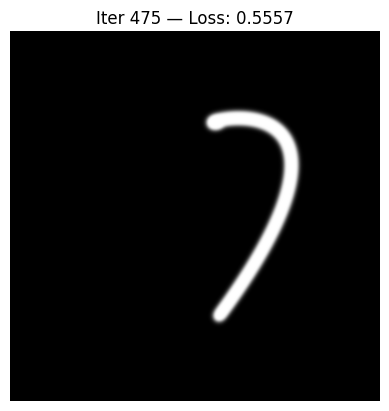

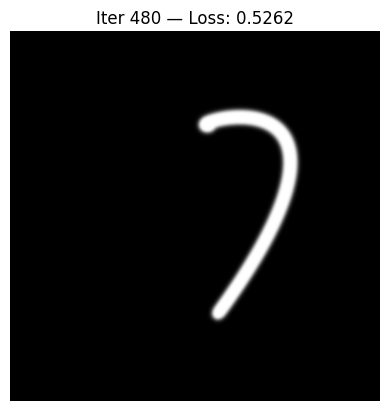

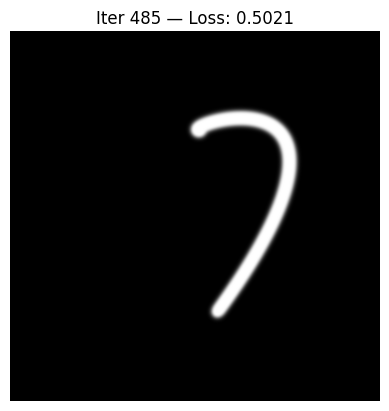

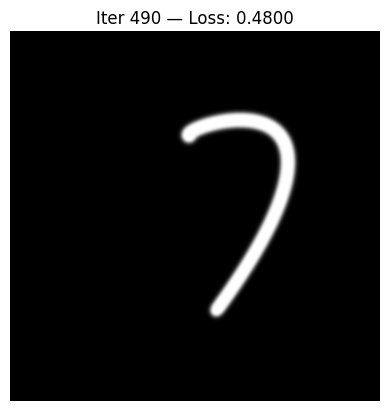

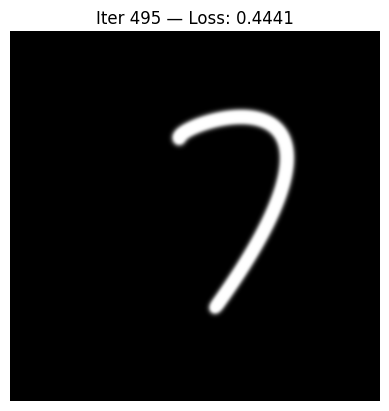

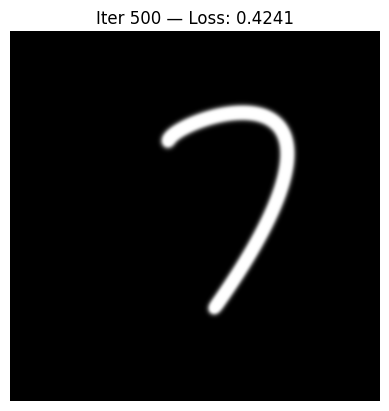

In [8]:
import math
import json
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ——— Your rasterizer (already optimized / compiled) ———
# (Assuming you’ve already defined rasterize_spheres somewhere above,
#  and wrapped it with torch.compile as below)
rasterizer = torch.compile(rasterize_spheres)

# ——— Helper class to manage a dynamic set of Bézier curves ———
class CurveSet(nn.Module):
    def __init__(self, init_pts_list, thickness=0.02, overlap=0.8, arc_samples=300, device='cuda'):
        super().__init__()
        self.curves = nn.ModuleList([
            BezierCurve(pts.to(device), thickness, overlap, arc_samples, device=device)
            for pts in init_pts_list
        ])
        self.device = device

    def forward(self):
        means_list, th_list = [], []
        for curve in self.curves:
            m, t = curve()   # (M_i, 3), (M_i,)
            means_list.append(m)
            th_list.append(t)
        means = torch.cat(means_list, dim=0)       # (N,3)
        thicknesses = torch.cat(th_list, dim=0)    # (N,)
        return means, thicknesses

    def remove_curve(self, idx):
        """Remove the curve at index `idx` (0-based)."""
        if idx < 0 or idx >= len(self.curves):
            raise IndexError(f"No curve at index {idx}")
        del self.curves[idx]


# ——— Main training script ———

# Force CUDA usage
device = 'cuda'
W, H = 800, 800

# Loss and optimizer setup
criterion = nn.BCELoss()

# Load your scene (on CUDA)
_, c2w_all, K = load_scene("../data/transforms_train.json", W, H, device)
c2w0 = c2w_all[0]
w2c0 = torch.linalg.inv(c2w0)

# Load target image
to_tensor = T.ToTensor()
target = Image.open("../data/test.jpeg").convert("L").resize((W, H))
target_t = to_tensor(target).to(device)      # (1,H,W)
target_t = 1 - target_t
target_t = (target_t > 0.5).float()          # binarize

# Your initial control‐point tensors
init_pts1 = torch.tensor([
    [-0.3,  0.0, 0.0],
    [ 0.0,  0.3, 0.2],
    [ 0.4, -0.3, 0.2],
    [ 0.7,  0.0, 0.0]
], device=device)
init_pts2 = torch.tensor([
    [ 0.3,  0.0, 0.0],
    [ 0.0,  0.3, 0.2],
    [ 0.4, -0.3, 0.2],
    [ 0.7,  0.0, 0.0]
], device=device)

# Create the CurveSet with exactly the curves you have
curve_set = CurveSet([init_pts1, init_pts2], thickness=0.02, overlap=0.8, arc_samples=300, device=device)
curve_set.to(device)

# Optimizer over all curve parameters
opt = optim.Adam(curve_set.parameters(), lr=1e-2)

# Prepare plotting
plt.ion()
fig = plt.figure(figsize=(6, 6))

# Training loop
for it in range(501):
    opt.zero_grad()

    # Render all curves
    means, thicknesses = curve_set()  # (N,3), (N,)
    img = rasterizer(means, thicknesses, w2c0, K, W, H)  # (H,W,1)
    img = img.permute(2, 0, 1)                            # (1,H,W)

    # Compute loss and backprop
    loss = criterion(img, target_t)
    loss.backward()
    opt.step()

    # Example: remove the first curve at iteration 200
    if it == 200 and len(curve_set.curves) > 0:
        curve_set.remove_curve(0)
        # Rebuild optimizer so the removed curve's params are dropped
        opt = optim.Adam(curve_set.parameters(), lr=1e-2)

    # Plot every 5 iterations
    if it % 5 == 0:
        curr = img[0].detach().cpu().numpy()
        plt.clf()
        plt.imshow(curr, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Iter {it:3d} — Loss: {loss.item():.4f}")
        plt.axis('off')
        plt.pause(0.1)

plt.ioff()
plt.show()

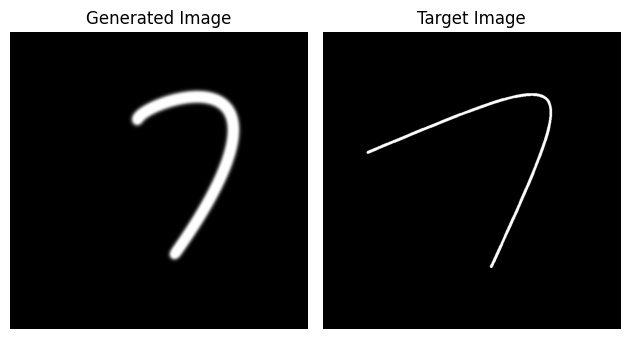

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img.cpu().detach().numpy()[0], cmap='gray', vmin=0, vmax=1)
plt.title("Generated Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(target_t[0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Target Image")
plt.axis('off')
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_spheres(means: np.ndarray, radii: np.ndarray, resolution: int = 20):
    """
    Plot 3D spheres centered at `means` with given `radii`.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,) numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2*np.pi, resolution)
    v = np.linspace(0, np.pi,   resolution)
    uu, vv = np.meshgrid(u, v)

    fig = go.Figure()

    for (x0, y0, z0), r in zip(means, radii):
        # sphere surface at center (x0,y0,z0)
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        fig.add_trace(go.Surface(
            x=x, y=y, z=z,
            showscale=False,
            opacity=0.6,
            lighting=dict(ambient=0.5, diffuse=0.5, roughness=0.9),
            hoverinfo='skip'
        ))

    # make axes equal and add some padding
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', backgroundcolor="rgb(230, 230,230)"),
            yaxis=dict(title='Y', backgroundcolor="rgb(230, 230,230)"),
            zaxis=dict(title='Z', backgroundcolor="rgb(230, 230,230)"),
            aspectmode='data'
        ),
        width=800, height=800,
        title="3D Spheres at Bézier Sample Locations"
    )

    fig.show()


# --- Example usage ---

# assuming you have your torch tensors `means` and `thicknesses` already:
import torch

# means: (N,3) tensor on CPU or GPU
# thicknesses: (N,) world‐space radii
means_np = means.detach().cpu().numpy()
radii_np = thicknesses.detach().cpu().numpy()

plot_spheres(means_np, radii_np)